In [3]:
from __future__ import annotations
from typing import Optional, Tuple
import pandas as pd 
from copy import deepcopy
from scipy.stats.contingency import odds_ratio
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import seaborn as sns
import numpy as np

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

**Load data**

In [4]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEER_2010_2020.clean.tsv'
master = pd.read_csv(INFILE, header=0, sep='\t', na_values='.')

In [5]:
# basic formatting
from util_funcs import do_basic_formatting
from util_funcs import do_basic_filtering

print('\nBasic filtering')
df = do_basic_filtering(master)

HISTTYPES_PATH = '/home/grace/work/SEER/data/histology/histcodes.tsv'
print('\nBasic formatting')
df = do_basic_formatting(df, HISTTYPES_PATH)

df.head()


Basic filtering
Removing records not in range (2010, 2020)
- removed 434173 records
Selecting records with MALIGNANT behavior
- removed 635849 records
Handling patients with multiple records of same cancer_type
- removed 81659 records
Removing records where any met value (except distant LN) is missing
- removed 722084 records

Final records: 3810345, patients: 3608812

Basic formatting
Missing 0 codes.
Formatting cancer subtypes
TNG, Grade standardisation


,patient_id,patient_death_year,diagnosis_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,distant_ln,any_met,hist_type_descr,TSTAGE_STD,NSTAGE_STD,GSTAGE_STD,GRADE_STD
4,124,"2,011.00",2010,70-74 years,Breast,Breast,Breast,Breast,T3,N0,IIB,NaN,NaN,NaN,G3,NaN,NEG,MALIGNANT,3,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NaN,NO,Infiltrating duct carcinoma [+ others],T3,N0,II,G3
5,125,NaN,2018,70-74 years,Breast,Breast,Breast,Breast,T2,N0,IIA,NaN,NaN,NaN,G3,P,NEG,MALIGNANT,2,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,False,NO,Infiltrating duct carcinoma [+ others],T2,N0,II,G3
6,179,NaN,2016,55-59 years,Ovary,Ovary,Ovary,Ovary,T1c,N0,IC,P,P,NaN,G2,NaN,NEG,MALIGNANT,2,0,NaN,NaN,8441,"cystic, mucinous and serous neoplasms",NO,NO,NO,NO,False,NO,Serous carcinoma [+ others],T1,N0,I,G2
7,203,NaN,2011,70-74 years,Prostate,Prostate,Prostate,Prostate,T1c,N0,II,NaN,NaN,NaN,G2,NaN,NaN,MALIGNANT,2,0,6.60,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NaN,NO,Adenoma [+ others],T1,N0,II,G2
8,239,"2,016.00",2011,65-69 years,Prostate,Prostate,Prostate,Prostate,T2c,N0,II,NaN,NaN,NaN,G3,NaN,NaN,MALIGNANT,2,0,7.70,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NaN,NO,Adenoma [+ others],T2,N0,II,G3


In [10]:

FIELD_BRAIN_PREFERENCE = 'p( BRAIN MET | ANY MET )'
FIELD_NUM_RECORDS = 'NUM RECORDS'

# BRAIN_PREFERENCE_MEASURE = 'BRAIN PREFERENCE MEASURE'
def calculate_met_rates(pred: str, df: pd.DataFrame) -> Tuple:
        
    # df for raw case counts
    counts = pd.DataFrame()

    METS = ['brain_met', 'bone_met', 'lung_met', 'liver_met', 'any_met']
    for met in METS:
        yn_df = df.groupby(by=[pred, met]).size().unstack(fill_value=0)
        if 'YES' not in yn_df.columns:
            yn_df['YES'] = 0
        if 'NO' not in yn_df.columns:
            yn_df['NO'] = 0
        counts[met + '_NO'] = yn_df['NO']
        counts[met + '_YES'] = yn_df['YES']

    df[(df['brain_met']=='YES') & (df['brain_met']=='YES')]
    # df for prevalence
    prevs = pd.DataFrame()
    for res in METS:
        prevs[res] = counts[res + '_YES'] / (counts[res + '_NO'] + counts[res + '_YES'])

    return counts, prevs

def run_met_rates(
    df: pd.DataFrame,
    predictors: list[str], 
    subsets: Optional[dict]=None,
    min_observations: int=1000,
    metric: str='prevalence'
    ) -> pd.DataFrame:
    assert metric in ['prevalence', 'condprob']

    if metric == 'condprob':
        df = df[df['any_met']=='YES']

    if subsets:
        for field, vlist in subsets.items():
            df = df.loc[df[field].isin(vlist)]
        
    if len(predictors) == 0:
        raise ValueError
    elif len(predictors) == 1:
        pred = predictors[0]
    else:
        # TODO in development, weird behaviour
        print(f'\n Predictors: {predictors}')
        print(f'Before NAdrop: {df.shape[0]}')
        df = df.dropna(subset=predictors, thresh=1)
        print(f'After NAdrop: {df.shape[0]}')
        pred = ': '.join(predictors)
        for item in predictors:
            df[item] = df[item].apply(str)
        df[pred] = df[predictors].agg(': '.join, axis=1)
    
    df = df.groupby(pred).filter(lambda x : len(x) >= min_observations)

    counts, prevs = calculate_met_rates(pred, df)
    METS = ['brain_met', 'bone_met', 'lung_met', 'liver_met', 'any_met']
    summ = prevs[METS]
    summ[FIELD_NUM_RECORDS] = counts['any_met_NO'] + counts['any_met_YES']

    # prevalence to percent % 
    if metric == 'prevalence':
        for field in METS:
            summ[field] = prevs[field] * 100
            
    return summ


In [27]:
import os 

def plot_condprob_heatmap(
    df: pd.DataFrame,
    groups: list[str],
    subdir_override: Optional[str]=None,
    ) -> None:
    LARGE_VALUE = 100000000000000
    pd.set_option('display.max_rows', 50)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 150)
    pd.options.display.float_format = "{:,.2f}".format
        
    MAX_ROWS = 200
    rowcount = df.shape[0]
    if rowcount > MAX_ROWS:
        print('Num rows exceeds MAX_ROWS!!')
    df = df.head(MAX_ROWS)
    df = df.sort_values(by='any_met', ascending=False)
    condprobs = df.drop([FIELD_NUM_RECORDS], axis=1)
    cases1D = df[[FIELD_NUM_RECORDS]]
    
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, (rowcount//2)+4), gridspec_kw={'width_ratios':[5,1]}, layout="compressed")
    a1 = axs[0].matshow(condprobs, cmap='rocket_r', vmax=2)
    axs[1].matshow(cases1D, cmap='binary', vmax=LARGE_VALUE)

    flat_axes = axs.flat
    flat_data = [condprobs, cases1D]
    for i, (ax, data) in enumerate(zip(flat_axes, flat_data)):
        data_matrix = data.T.to_numpy()
        for (x, y), value in np.ndenumerate(data_matrix):
            if i % 2 == 1:
                ax.text(x-0.5, y, f"{value}", va="center", ha="left")
            else:
                ax.text(x, y, f"{value:.1f}", va="center", ha="center")
        
        # first col: add y ticks
        if i % 4 == 0:
            ytick_marks = np.arange(len(data.index))
            ax.set_yticks(ytick_marks, data.index)
            # ax.set_ylabel(data.index.name)
        else:
            ax.set_yticks([])
        
        # first row: add x ticks
        xtick_marks = np.arange(len(data.columns))
        ax.set_xticks(xtick_marks, data.columns, rotation=90)

        # third row: remove frame 
        if i % 4 == 1:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.tick_params(left = False, top = False, bottom = False)
    
    # titles & saving
    group_lab = ':'.join(groups)
    title = f'{group_lab}'
    plt.suptitle(title, y=1.03, fontsize='x-large')
    title_fmtd = title.strip()
    title_fmtd = title_fmtd.split(' vs ')[0]
    title_fmtd = title_fmtd.replace('_', '')
    title_fmtd = title_fmtd.replace(': ', '_')
    title_fmtd = title_fmtd.lower()

    if subdir_override:
        filepath = f'/home/grace/work/SEER/outputs/heatmaps/condprob/{subdir_override}/{group_lab}.png'
    else:
        filepath = f'/home/grace/work/SEER/outputs/heatmaps/condprob/{group_lab}.png'
    os.makedirs(filepath.rsplit('/', 1)[0], exist_ok=True)
    plt.savefig(filepath)
    print(filepath)

def plot_prevalence_heatmaps(
    df: pd.DataFrame,
    groups: list[str],
    subdir_override: Optional[str]=None,
    ) -> None:
    LARGE_VALUE = 100000000000000
    pd.set_option('display.max_rows', 50)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 150)
    pd.options.display.float_format = "{:,.2f}".format
        
    MAX_ROWS = 200
    rowcount = df.shape[0]
    if rowcount > MAX_ROWS:
        print('Num rows exceeds MAX_ROWS!!')
    df = df.head(MAX_ROWS)

    SORTCOLS = ['any_met', 'brain_met', FIELD_BRAIN_PREFERENCE]
    LABELS = ['anyrate', 'brainrate', 'braintend']
    for sortcol, label in zip(SORTCOLS, LABELS):
        df = df.sort_values(by=sortcol, ascending=False)
        freqs = df.drop([FIELD_NUM_RECORDS, FIELD_NUM_RECORDS + '(met)', FIELD_BRAIN_PREFERENCE], axis=1)
        basecases1D = df[[FIELD_NUM_RECORDS]]
        tend1D = df[[FIELD_BRAIN_PREFERENCE]]
        metcases1D = df[[FIELD_NUM_RECORDS + '(met)']]
        
        fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(12, (rowcount//2)+4), gridspec_kw={'width_ratios':[5,1,1,1]}, layout="compressed")
        a1 = axs[0].matshow(freqs, cmap='rocket_r', vmax=80)
        axs[1].matshow(basecases1D, cmap='binary', vmax=LARGE_VALUE)
        axs[2].matshow(tend1D, cmap='PiYG_r', vmin=-0.3, vmax=0.4)
        axs[3].matshow(metcases1D, cmap='binary', vmax=LARGE_VALUE)

        flat_axes = axs.flat
        flat_data = [freqs, basecases1D, tend1D, metcases1D]
        for i, (ax, data) in enumerate(zip(flat_axes, flat_data)):
            data_matrix = data.T.to_numpy()
            for (x, y), value in np.ndenumerate(data_matrix):
                if i % 4 in [1, 3]:
                    ax.text(x-0.5, y, f"{value}", va="center", ha="left")
                elif i % 4 == 2:
                    ax.text(x, y, f"{value:.2f}", va="center", ha="center")
                else:
                    ax.text(x, y, f"{value:.1f}", va="center", ha="center")
            
            # first col: add y ticks
            if i % 4 == 0:
                ytick_marks = np.arange(len(data.index))
                ax.set_yticks(ytick_marks, data.index)
                # ax.set_ylabel(data.index.name)
            else:
                ax.set_yticks([])
            
            # first row: add x ticks
            xtick_marks = np.arange(len(data.columns))
            ax.set_xticks(xtick_marks, data.columns, rotation=90)

            # third row: remove frame 
            if i % 4 in [1, 3]:
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
            ax.tick_params(left = False, top = False, bottom = False)
        
        # titles & saving
        group_lab = ':'.join(groups)
        title = f'{group_lab}'
        plt.suptitle(title, y=1.03, fontsize='x-large')
        title_fmtd = title.strip()
        title_fmtd = title_fmtd.split(' vs ')[0]
        title_fmtd = title_fmtd.replace('_', '')
        title_fmtd = title_fmtd.replace(': ', '_')
        title_fmtd = title_fmtd.lower()

        if subdir_override:
            filepath = f'/home/grace/work/SEER/outputs/heatmaps/prevalence/{subdir_override}/{group_lab}_{label}.png'
        else:
            filepath = f'/home/grace/work/SEER/outputs/heatmaps/prevalence/{group_lab}/{label}.png'
        os.makedirs(filepath.rsplit('/', 1)[0], exist_ok=True)
        plt.savefig(filepath)
        print(filepath)


In [21]:
MIN_FEATURE_OBSERVATIONS = 1000

# features = ['cancer_group']
features = ['TSTAGE_STD']
subsets = None
extra_label = ''
maintable = run_met_rates(df=df, predictors=features, metric='prevalence')
mettable = run_met_rates(df=df, predictors=features, metric='condprob')
print(maintable.head())
print(mettable.head())

maintable[FIELD_BRAIN_PREFERENCE] = mettable['brain_met']
maintable[FIELD_NUM_RECORDS + '(met)'] = mettable[FIELD_NUM_RECORDS]

print(maintable.head())

            brain_met  bone_met  lung_met  liver_met  any_met  NUM RECORDS
TSTAGE_STD                                                                
T1               0.55      1.68      0.98       1.23     3.43      1421000
T2               1.86      4.63      2.81       3.80     9.94       848684
T3               1.38      4.24      5.16       7.88    14.39       548868
T4               6.86     14.99     17.40      14.82    36.30       337171
            brain_met  bone_met  lung_met  liver_met  any_met  NUM RECORDS
TSTAGE_STD                                                                
T1               0.16      0.49      0.28       0.36     1.00        48805
T2               0.19      0.47      0.28       0.38     1.00        84372
T3               0.10      0.29      0.36       0.55     1.00        78985
T4               0.19      0.41      0.48       0.41     1.00       122403
            brain_met  bone_met  lung_met  liver_met  any_met  NUM RECORDS  p( BRAIN MET | ANY MET )

/home/grace/work/SEER/outputs/heatmaps/condprob/cancer_group.png


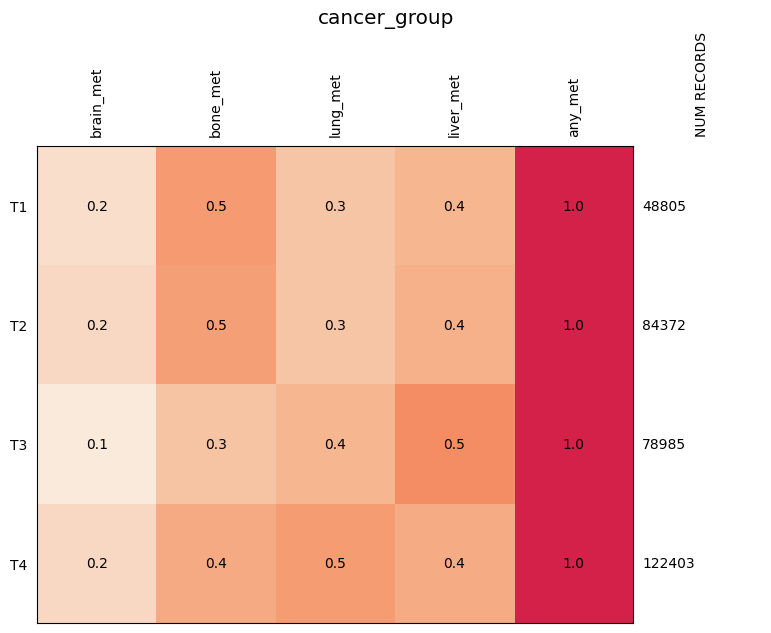

In [28]:
plot_condprob_heatmap(mettable, groups=['cancer_group'])

In [ ]:
plot_prevalence_heatmaps(maintable, groups=['cancer_group'])

**Addressing tumors where 'site recode' is mismatch to 'primary site'**

For patients with single record, these only occur when 'site recode' is a cancer_type of nebulous location. <br>
Specifically, Lymphomas. 

Necessary because SEER 'site recode' and 'primary site' mean different things. 

site recode (cancer_type)
- cancer type rather than 'site' (eg Hodgkin Lymphoma)

primary site (primary_type)
- location of primary tumor. 
- organ (eg lung), or region (eg Bones and Joints) 
- in the case of Hodgkin Lymphoma etc, primary site could be any general location as lymph nodes are spread around the body. 
    

aslkdj
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [ ]:
singles_df = master.drop_duplicates(subset=['patient_id'], keep=False)
multiples_df = master[master.duplicated(subset=['patient_id'], keep=False)]

In [ ]:
singles_df = master.drop_duplicates(subset=['patient_id'], keep=False)
multiples_df = master[master.duplicated(subset=['patient_id'], keep=False)]

In [ ]:
singles_df = master.drop_duplicates(subset=['patient_id'], keep=False)
singles_df = singles_df.loc[singles_df['cancer_type'] != 'Brain']
multiples_df = master[master.duplicated(subset=['patient_id'], keep=False)]
master.head()

In [ ]:
def override_primary_types(df: pd.DataFrame) -> pd.DataFrame:
    # if unsure between melanoma & non-melanoma, non-melanoma more common so guess this label.
    df.loc[df['primary_type']=='Melanoma of the Skin | Other Non-Epithelial Skin', 'primary_type'] = 'Other Non-Epithelial Skin'

    # override primary_type for cancer_types where the primary tumor can appear in variable locations in the body. 
    for ctype in [
        'NHL - Extranodal',
        'Mesothelioma',
        'Kaposi Sarcoma',
        'Myeloma',
        'Hodgkin - Extranodal',
        'Other Myeloid/Monocytic Leukemia',
    ]:
        # print()
        # print(df.loc[(df['cancer_type']!=df['primary_type']) & (df['cancer_type']==ctype)].head())
        # print()
        df.loc[(df['cancer_type']!=df['primary_type']) & (df['cancer_type']==ctype), 'primary_type'] = ctype
    return df

def summarise_mismatches(df: pd.DataFrame) -> None:
    mm_df = df[df['cancer_type'] != df['primary_type']][['cancer_type', 'primary_type']]
    mm_df['mismatches'] = mm_df['cancer_type'] + ' | ' + mm_df['primary_type']
    print(f'\nTotal mismatches: {mm_df.shape[0]}')
    print(mm_df['mismatches'].value_counts().head(10))

summarise_mismatches(singles_df)
singles_df = override_primary_types(singles_df)
summarise_mismatches(singles_df)


Propensity 

In [ ]:
# def bool_to_yes_no(df: pd.DataFrame, fields: list[str]) -> pd.DataFrame:
#     for field in fields:
#         df[field] = df[field].apply(lambda x: 'YES' if x else 'NO')
#     return df 


In [ ]:
mismatch_pids = master[master['cancer_type'] != master['primary_type']]['patient_id']
mismatch_pids = set(mismatch_pids.to_list())
mismatch_df = master[master['patient_id'].isin(mismatch_pids)][['patient_id', 'diagnosis_year', 'cancer_type', 'primary_type', 'primary_group']]

# separate to patients with single record vs multiple records
mm_singles_df = mismatch_df.drop_duplicates(subset=['patient_id'], keep=False)
mm_multiples_df = mismatch_df[mismatch_df.duplicated(subset=['patient_id'], keep=False)]


In [ ]:
# fix primary_type labels for patients with multiple tumors. 

# example 1 ---
# idx   diagnosis_year  patient_id	    cancer_type	            primary_type
# 1     2013            3226	        Melanoma of the Skin	Melanoma of the Skin
# 2     2015            3226	        NHL - Extranodal	    Melanoma of the Skin | Other Non-Epithelial Skin
# 3     2018            3226	        Melanoma of the Skin	Melanoma of the Skin
# ^ idx==2 change primary_type to 'Melanoma of the Skin' 

# example 2 ---
# idx   diagnosis_year  patient_id	    cancer_type	            primary_type
# 1     2011            9833	        Myeloma	                Bones and Joints
# 2     2011            9833	        Myeloma	                Myeloma
# ^ idx==1 change primary_type to 'Myeloma' 

def select_primary_fields(tumors: list[Tuple]) -> Tuple[str | None, str | None]:
    selected_ptype = None
    selected_pgroup = None
    
    min_year = min(t[0] for t in tumors)
    minyear_types = set([t[2] for t in tumors if t[0] == min_year])
    agreement_types = set([t[2] for t in tumors if t[1] == t[2]])
    intersection_types = minyear_types & agreement_types 
    unique_types = set([t[2] for t in tumors])

    # single tumor at first contact, and the cancer_type matches the primary_type
    if len(intersection_types) == 1:
        selected_ptype = intersection_types.pop()
    
    elif len(unique_types) == 1:
        selected_ptype = unique_types.pop()
    
    if selected_ptype:
        selected_pgroup = [t[3] for t in tumors if selected_ptype in t[2]][0]
        return selected_ptype, selected_pgroup
 
    return None, None

def update_primary_fields(pid: str, ptype: str, pgroup: str, df: pd.DataFrame) -> None:
    mm_df = df[df['patient_id'] == pid]
    mm_df = mm_df[mm_df['primary_type'] != ptype]

    for idx, row in mm_df.iterrows():
        # example 2 idx 1
        if row['cancer_type'] == ptype:
            df.loc[idx, 'primary_type'] = ptype
            df.loc[idx, 'primary_group'] = pgroup
            assert df.loc[idx]['primary_type'] == ptype
            assert df.loc[idx]['primary_group'] == pgroup
        # example 1 idx 2
        # '|' situation
        elif ptype in row['primary_type']:
            df.loc[idx, 'primary_type'] = ptype
            df.loc[idx, 'primary_group'] = pgroup
            assert df.loc[idx]['primary_type'] == ptype
            assert df.loc[idx]['primary_group'] == pgroup
        else:
            continue 

pids = mm_multiples_df['patient_id'].unique()
print(f'PIDs to process: {len(pids)}')
for i, pid in enumerate(pids):
    # subset dataframe to just this patient
    pid_df = mm_multiples_df[mm_multiples_df['patient_id'] == pid]
    records = pid_df[['diagnosis_year', 'cancer_type', 'primary_type', 'primary_group']].to_records(index=False).tolist()
    ptype, pgroup = select_primary_fields(records)
    if ptype and pgroup:
        update_primary_fields(pid, ptype, pgroup, master)
    if i % 1000 == 0:
        print(f'processed {i} pids.')


In [ ]:

# # single mismatches are common for cancer_type of widespread region. eg lymphomas / leukemia. 
# # this is because site and primary_site mean different things in SEER. 
# combinations = pd.DataFrame()
# combinations['cancer_type'] = mm_singles_df['cancer_type']
# combinations['primary_type'] = mm_singles_df['primary_type']
# combinations['cancer_type && primary_type'] = combinations['cancer_type'] + ' && ' + combinations['primary_type']

# """
# NHL - Extranodal                    47750
# Mesothelioma                         7491
# Kaposi Sarcoma                       3755
# Myeloma                              2262
# Hodgkin - Extranodal                  331
# Other Myeloid/Monocytic Leukemia      227
# """
# print(combinations['cancer_type'].value_counts())
# print('\nNHL - Extranodal ---')
# print(combinations[combinations['cancer_type'] == 'NHL - Extranodal']['primary_type'].value_counts().head(10))
# print('\nMesothelioma ---')
# print(combinations[combinations['cancer_type'] == 'Mesothelioma']['primary_type'].value_counts().head(10))
# print('\nKaposi Sarcoma ---')
# print(combinations[combinations['cancer_type'] == 'Kaposi Sarcoma']['primary_type'].value_counts().head(10))
# print('\nMyeloma ---')
# print(combinations[combinations['cancer_type'] == 'Myeloma']['primary_type'].value_counts().head(10))
# print('\n')


In [ ]:
# fix primary_type labels for special cases. 

# example 1 ---
# idx   diagnosis_year  patient_id	    cancer_type	            primary_type
# 1     2013            3226	        Melanoma of the Skin	Melanoma of the Skin
# 2     2015            3226	        NHL - Extranodal	    Melanoma of the Skin | Other Non-Epithelial Skin
# 3     2018            3226	        Melanoma of the Skin	Melanoma of the Skin
# ^ idx==2 change primary_type to 'Melanoma of the Skin' 

# example 2 ---
# idx   diagnosis_year  patient_id	    cancer_type	            primary_type
# 1     2011            9833	        Myeloma	                Bones and Joints
# 2     2011            9833	        Myeloma	                Myeloma
# ^ idx==1 change primary_type to 'Myeloma' 

mismatch_pids = master[master['cancer_type'] != master['primary_type']]['patient_id']
mismatch_pids = set(mismatch_pids.to_list())
mismatch_df = master[master['patient_id'].isin(mismatch_pids)][['patient_id', 'diagnosis_year', 'cancer_type', 'primary_type', 'primary_group', 'hist_cateogry']]

# separate to patients with single record vs multiple records
mm_singles_df = mismatch_df.drop_duplicates(subset=['patient_id'], keep=False)
mm_multiples_df = mismatch_df[mismatch_df.duplicated(subset=['patient_id'], keep=False)]
temp = mm_multiples_df.head()

for pid in temp['patient_id'].unique():
    sel_ptype = None
    sel_pgroup = None
    
    # subset dataframe to just this patient
    pid_df = temp[temp['patient_id'] == pid]
    
    # get rows relating to tumors at earliest timepoint
    pid_init_df = pid_df[pid_df['diagnosis_year']==pid_df['diagnosis_year'].min()]
    if pid_init_df.shape[0] == 1:
        sel_ptype = pid_init_df.iloc[0]['primary_type']
        sel_pgroup = pid_init_df.iloc[0]['primary_group']

    # check if any agreement between cancer_type and primary_type
    # example 1, idx 1 above is agreement. 
    # example 2, idx 1 above is disagreement. 
    # example 2, idx 2 above is agreement. 
    pid_agree_df = pid_init_df[pid_init_df['cancer_type'] == pid_init_df['primary_type']]
    if pid_agree_df.shape[0] >= 1:
        sel_ptype = pid_init_df.iloc[0]['primary_type']
        sel_pgroup = pid_init_df.iloc[0]['primary_group']

    assert sel_ptype
    assert sel_pgroup
    # get rows with mismatches
    pid_mm_df = pid_df[pid_df['cancer_type'] != pid_df['primary_type']]
    # print(pid_mm_df)
    # do fixes
    for idx, row in pid_mm_df.iterrows():
        # print(idx)
        update_success = False

        # example 2 idx 1 scenario fix
        old_ptype = row['primary_type']
        if row['cancer_type'] == sel_ptype:
            # print(temp)
            temp.loc[idx]['primary_type'] = sel_ptype
            temp.loc[idx]['primary_group'] = sel_pgroup
            # print(temp)
            update_success = True
        # example 1 idx 2 scenario fix
        elif '|' in old_ptype:
            options = old_ptype.split('|')
            for opt in options:
                if opt.strip() == sel_ptype:
                    print(temp)
                    temp.loc[idx]['primary_type'] = sel_ptype
                    temp.loc[idx]['primary_group'] = sel_pgroup
                    update_success = True
                    break
        if not update_success:
            print(temp)
            print(sel_ptype)
            print(sel_pgroup)
            print(temp)
            raise RuntimeError

    # does this work? 
    # print(temp[temp['patient_id'] == pid])
    break 
    


# # single mismatches are odd
# combinations = pd.DataFrame()
# combinations['cancer_type'] = mm_singles_df['cancer_type']
# combinations['primary_type'] = mm_singles_df['primary_type']
# combinations['cancer_type && primary_type'] = combinations['cancer_type'] + ' && ' + combinations['primary_type']
# """
# NHL - Extranodal                    47750
# Mesothelioma                         7491
# Kaposi Sarcoma                       3755
# Myeloma                              2262
# Hodgkin - Extranodal                  331
# Other Myeloid/Monocytic Leukemia      227
# """

# # print(combinations['cancer_type'].value_counts().head(20))
# print(combinations[combinations['cancer_type'] == 'NHL - Extranodal']['primary_type'].value_counts().head(20))
